# Exploratoyry Data Analysis

In [14]:
from pyspark.sql import SparkSession
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, sum as Fsum
from pyspark.sql.types import DoubleType, IntegerType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation


In [4]:
# Spark Session
spark = SparkSession.builder \
    .appName("YellowTaxiTripPrediction") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

25/05/10 17:32:13 WARN Utils: Your hostname, inigo-pena-HP-Victus resolves to a loopback address: 127.0.1.1; using 192.168.1.141 instead (on interface wlo1)
25/05/10 17:32:13 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/10 17:32:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/05/10 17:32:14 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/05/10 17:32:14 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


### 1- Columns and variable type

In [5]:
df = spark.read.csv("../data/full_tripdata.parquet", header=False, inferSchema=True)

column_names = [
    "PULocationID", "DOLocationID", "passenger_count", "tpep_pickup_datetime", "tpep_dropoff_datetime",
    "VendorID", "trip_distance", "payment_type", "fare_amount", "tip_amount", "total_amount",
    "hour", "day_of_week", "trip_duration_seconds", "speed_mph", "extras",
    "PU_Borough", "PU_Zone", "DO_Borough", "DO_Zone"
]
df = df.toDF(*column_names)

df.printSchema()

root
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- VendorID: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- hour: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- trip_duration_seconds: double (nullable = true)
 |-- speed_mph: double (nullable = true)
 |-- extras: double (nullable = true)
 |-- PU_Borough: string (nullable = true)
 |-- PU_Zone: string (nullable = true)
 |-- DO_Borough: string (nullable = true)
 |-- DO_Zone: string (nullable = true)



### 2- Resume about every column

In [8]:
df.describe().show()

+-------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+------------------+------------------+-----------------+---------------------+------------------+------------------+----------+--------------------+----------+--------------------+
|summary|      PULocationID|      DOLocationID|   passenger_count|          VendorID|    trip_distance|      payment_type|       fare_amount|       tip_amount|      total_amount|              hour|      day_of_week|trip_duration_seconds|         speed_mph|            extras|PU_Borough|             PU_Zone|DO_Borough|             DO_Zone|
+-------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+------------------+------------------+-----------------+---------------------+------------------+------------------+----------+--------------------+----------+--

2.1 - NA/Null Values

In [7]:
df.select([Fsum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

+------------+------------+---------------+--------------------+---------------------+--------+-------------+------------+-----------+----------+------------+----+-----------+---------------------+---------+------+----------+-------+----------+-------+
|PULocationID|DOLocationID|passenger_count|tpep_pickup_datetime|tpep_dropoff_datetime|VendorID|trip_distance|payment_type|fare_amount|tip_amount|total_amount|hour|day_of_week|trip_duration_seconds|speed_mph|extras|PU_Borough|PU_Zone|DO_Borough|DO_Zone|
+------------+------------+---------------+--------------------+---------------------+--------+-------------+------------+-----------+----------+------------+----+-----------+---------------------+---------+------+----------+-------+----------+-------+
|           0|           0|              0|                   0|                    0|  185547|            0|           0|          0|         0|           0|   0|          0|                    0|        0|185547|         0|      0|        

The **VendorID** and **extras** columns are the only columns that have null values and they are plenty of them. We will may have to manage that.

### 3- Correlation Matrix

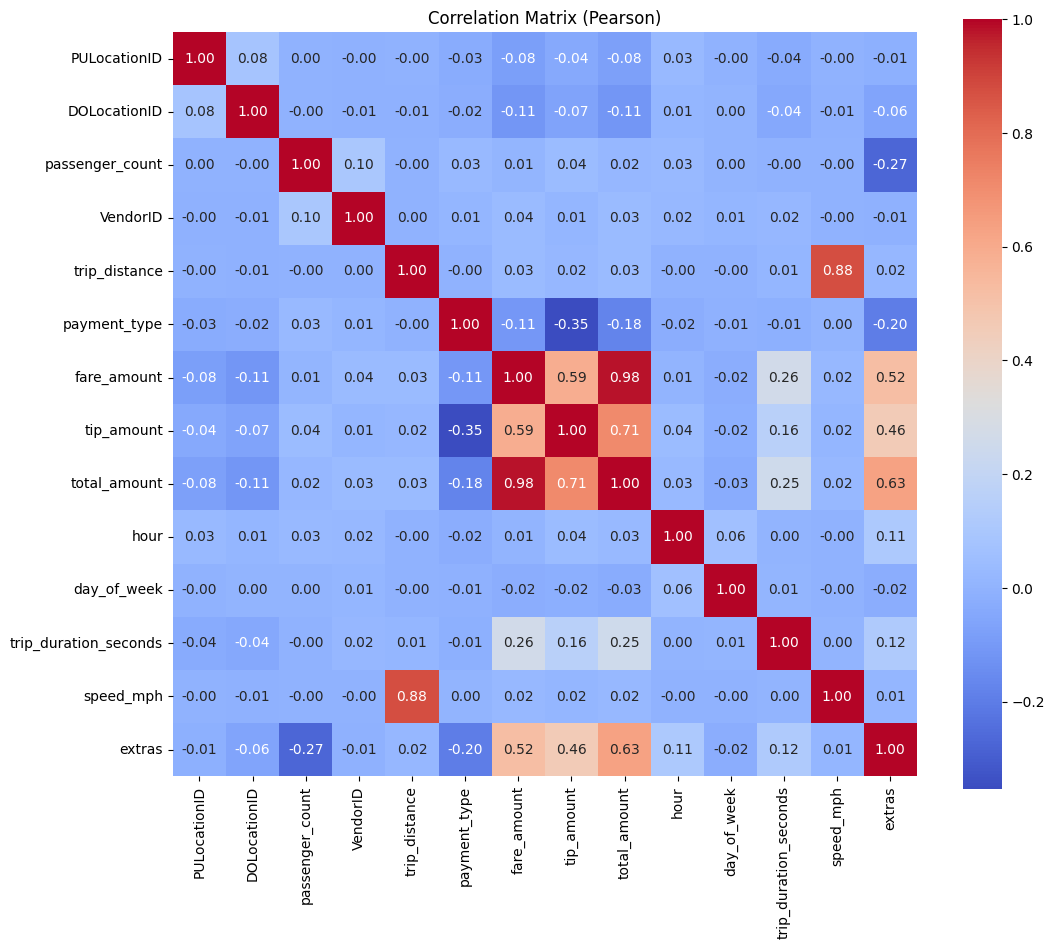

In [ ]:
numeric_cols = [field.name for field in df.schema.fields if isinstance(field.dataType, (DoubleType, IntegerType))]

# Clean NA
df_clean = df.select(numeric_cols).dropna()

assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
df_vector = assembler.transform(df_clean).select("features")

# Correlation Matrix
corr_matrix = Correlation.corr(df_vector, "features", "pearson").head()[0]
corr_array = corr_matrix.toArray()

corr_df = pd.DataFrame(corr_array, index=numeric_cols, columns=numeric_cols)

plt.figure(figsize=(12, 10))
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix (Pearson)")
plt.show()

The correlation matrix shows that total_amount is strongly correlated with fare_amount (0.98), trip_distance (0.71), and extras (0.63), which suggests potential data leakage. To build a meaningful predictive model, we should remove at least **fare_amount** and **tip_amount**, and maybe even **extras** from the features.